---

Load essential libraries

---

In [ ]:
import pandas as pd
import numpy as np
import math
import os
import sys
import datetime
import h5py 
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as dates
plt.style.use('dark_background')
%matplotlib inline
plt.rcParams['figure.figsize'] = (4.0, 4.0) # set default size of plots

---

Mount Google Drive folder if running Google Colab

---

In [3]:
## Mount Google drive folder if running in Colab
if('google.colab' in sys.modules):
    from google.colab import drive
    drive.mount('/content/drive', force_remount = True)
    DIR = '/content/drive/MyDrive/Colab Notebooks/MAHE/Research/MSIS_RandD/Hydraulics'
    DATA_DIR = DIR + '/Data/'
else:
    DATA_DIR = 'Data/'

---

Create dictionaries for HDF5 file creation

---

In [5]:
# Create a dictionary with file names of the sensors
sensor_files = {'PS1':'PS1.txt', 'PS2':'PS2.txt', 'PS3':'PS3.txt', 'PS4':'PS4.txt', 'PS5':'PS5.txt', 'PS6':'PS6.txt',
'EPS1':'EPS1.txt', 'FS1':'FS1.txt', 'FS2':'FS2.txt', 'TS1':'TS1.txt', 'TS2':'TS2.txt', 'TS3':'TS3.txt', 'TS4':'TS4.txt',
'VS1':'VS1.txt', 'CE':'CE.txt', 'CP':'CP.txt', 'SE':'SE.txt'}

label_file = DATA_DIR + 'profile.txt'
output_file = DATA_DIR + 'hydraulic_dataset.h5'

# Create a dictionary for the metadata
sensor_meta = {'PS1': ('Pressure', 'bar', 100),
               'PS2': ('Pressure', 'bar', 100),
               'PS3': ('Pressure', 'bar', 100),
               'PS4': ('Pressure', 'bar', 100),
               'PS5': ('Pressure', 'bar', 100),
               'PS6': ('Pressure', 'bar', 100),
               'EPS1': ('Motor Power', 'Watts', 100),
               'FS1': ('Volume Flow Rate', 'Litres/minute', 10),
               'FS2': ('Volume Flow Rate', 'Litres/minute', 10),
               'TS1': ('Temperature', 'Celsius', 1),
               'TS2': ('Temperature', 'Celsius', 1),
               'TS3': ('Temperature', 'Celsius', 1),
               'TS4': ('Temperature', 'Celsius', 1),
               'VS1': ('Vibration', 'mm/s', 1),
               'CE': ('Cooling Efficiency', 'Percentage', 1),
               'CP': ('Cooling Power', 'Kilowatts', 1),
               'SE': ('Efficiency Factor', '%', 1)
                }

# Read the labels
dfLabels = pd.read_csv(label_file, delimiter = '\t', header = None)
dfLabels.columns = ['cooler_condition', 'valve_condition', 'pump_leakage', 'accumulator_pressure', 'stable_flag']

---

Read multivariate timeseries data into the HDF5 file

---

In [6]:
sensor_data={}

for name, fname in sensor_files.items():
    sensor_data[name] = np.loadtxt(DATA_DIR + fname, delimiter = '\t')

# Write to HDF5 file
with h5py.File(output_file, 'w') as h5f:
    # Raw group
    raw_group = h5f.create_group('raw')

    for sensorname, sensordata in sensor_data.items():
        raw_group.create_dataset(sensorname, data = sensordata, compression = 'gzip')

    # Labels group
    label_group = h5f.create_group('labels')
    for col in dfLabels.columns:
        label_group.create_dataset(col, data = dfLabels[col].values, compression = 'gzip')

    # Metadata group
    metadata_group = h5f.create_group('metadata')
    metadata_group.create_dataset('sensor_names', data = np.array(list(sensor_meta.keys()), dtype = 'S'))
    metadata_group.create_dataset('units', data = np.array([v[1] for v in sensor_meta.values()], dtype = 'S'))
    metadata_group.create_dataset('sampling_rate', data = np.array([v[2] for v in sensor_meta.values()]))

    metadata_group.attrs['description'] = 'Hydraluic condition monitoring dataset with multiple sensor data'

---

Usage example

---

In [8]:
with h5py.File(output_file, 'r') as h5f:
    #print(f'Sensor names: {h5f['/raw'].keys()}')
    #print(f'Label names: {h5f['/labels'].keys()}')
    #print(f'Description: {h5f['/metadata'].attrs['description']}')
    #print(h5f['raw/PS1'][0:5])
    #print(h5f['/labels/cooler_condition'][:10])
    print(h5f['raw/PS1'][0][:3000])

[151.47 151.45 151.52 ... 166.35 166.32 166.38]


---

Read multiple sensor data from the hydraulics dataset

---

In [9]:
# List of sensor files with the file path
sensor_files = ['PS1.txt', 'FS1.txt', 'TS1.txt']

# Create an empty dictionary to store the sensor files data
data = dict.fromkeys([Path(f).stem for f in sensor_files])

# Read data from each sensor
for (sensor, value), file in zip(data.items(), sensor_files):
  data[sensor] = pd.read_csv(DATA_DIR + file, sep = "\t", header = None)

In [10]:
# Continue in a new code cell in your notebook

import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

output_file = DATA_DIR + 'hydraulic_dataset.h5' # Use the same output file path

# Dictionaries to store data and metadata
sensor_readings = {}
metadata = {}

with h5py.File(output_file, 'r') as h5f:
    # Get all sensor names from the metadata
    sensor_names = [name.decode('utf-8') for name in h5f['/metadata/sensor_names'][:]]

    # Get the sampling rates
    sampling_rates = h5f['/metadata/sampling_rate'][:]

    # Create a dictionary mapping sensor name to its sampling rate
    sensor_sampling_rates = {name: rate for name, rate in zip(sensor_names, sampling_rates)}

    # Load the data for PS1
    ps1_data = h5f['/raw/PS1'][:]

# Let's check the shape and the sampling rate for PS1
print(f"Shape of PS1 data: {ps1_data.shape}")
print(f"Sampling rate for PS1: {sensor_sampling_rates['PS1']} Hz")

Shape of PS1 data: (2205, 6000)
Sampling rate for PS1: 100 Hz


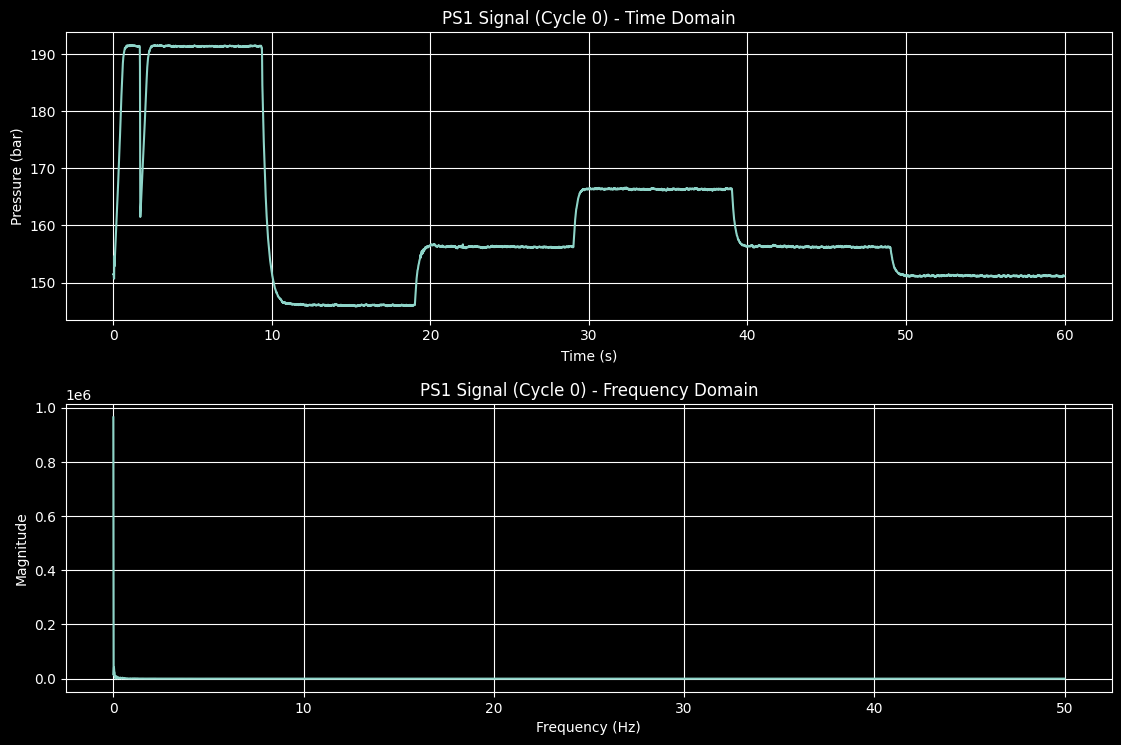

In [11]:
# feature extraction for the above loaded data

# Select one cycle to analyze (e.g., the first cycle)
cycle_index = 0
single_cycle_data = ps1_data[cycle_index]

# Number of sample points
N = len(single_cycle_data)
# Sampling rate (Hz)
fs = sensor_sampling_rates['PS1']

# Perform the FFT
yf = np.fft.fft(single_cycle_data)
xf = np.fft.fftfreq(N, 1 / fs)

# The FFT result is symmetric, so we only need the first half
yf_magnitude = np.abs(yf[:N//2])
xf_positive = xf[:N//2]

# --- Plotting ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
fig.tight_layout(pad=4.0)

# Plot 1: Time Domain Signal
time_vector = np.arange(N) / fs
ax1.plot(time_vector, single_cycle_data)
ax1.set_title(f'PS1 Signal (Cycle {cycle_index}) - Time Domain')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Pressure (bar)')
ax1.grid(True)

# Plot 2: Frequency Domain Signal (Spectrum)
ax2.plot(xf_positive, yf_magnitude)
ax2.set_title(f'PS1 Signal (Cycle {cycle_index}) - Frequency Domain')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Magnitude')
ax2.grid(True)

plt.show()

In [14]:
def extract_fft_features(signal, sampling_rate, num_peaks=5):
    """
    Extracts features from the frequency spectrum of a signal.

    Args:
        signal (np.array): A 1D array representing the time-series signal for one cycle.
        sampling_rate (int): The sampling rate of the signal in Hz.
        num_peaks (int): The number of top frequency peaks to extract.

    Returns:
        dict: A dictionary containing the extracted features.
    """
    N = len(signal)

    # Perform FFT
    yf = np.fft.fft(signal)
    xf = np.fft.fftfreq(N, 1 / sampling_rate)

    # Get the positive frequency spectrum
    yf_magnitude = np.abs(yf[:N//2])
    xf_positive = xf[:N//2]

    features = {}

    # Basic statistical features from the spectrum
    features['fft_mean'] = np.mean(yf_magnitude)
    features['fft_std'] = np.std(yf_magnitude)
    features['fft_max'] = np.max(yf_magnitude)

    # Find the top N peaks
    # We use argpartition to find the indices of the top peaks efficiently
    peak_indices = np.argpartition(yf_magnitude, -num_peaks)[-num_peaks:]
    # Sort the peaks by magnitude (descending)
    sorted_peak_indices = peak_indices[np.argsort(yf_magnitude[peak_indices])][::-1]

    for i in range(num_peaks):
        peak_idx = sorted_peak_indices[i]
        features[f'peak_freq_{i+1}'] = xf_positive[peak_idx]
        features[f'peak_mag_{i+1}'] = yf_magnitude[peak_idx]

    return features

# --- Test the function on our single cycle ---
fft_features = extract_fft_features(single_cycle_data, fs)
print("Extracted FFT Features for one cycle:")
for name, value in fft_features.items():
    print(f"  {name}: {value:.4f}")

Extracted FFT Features for one cycle:
  fft_mean: 428.8366
  fft_std: 17628.7658
  fft_max: 964040.9500
  peak_freq_1: 0.0000
  peak_mag_1: 964040.9500
  peak_freq_2: 0.0333
  peak_mag_2: 41124.9549
  peak_freq_3: 0.0500
  peak_mag_3: 25006.8575
  peak_freq_4: 0.0667
  peak_mag_4: 22983.9412
  peak_freq_5: 0.0167
  peak_mag_5: 13390.2306


In [15]:
# List to hold the feature dictionaries for each cycle
all_features = []
fs_ps1 = sensor_sampling_rates['PS1']

# Loop through every cycle in the PS1 data
for i in range(ps1_data.shape[0]):
    cycle_data = ps1_data[i]
    features = extract_fft_features(cycle_data, fs_ps1, num_peaks=5)
    all_features.append(features)

# Convert the list of dictionaries to a pandas DataFrame
df_features = pd.DataFrame(all_features)

print("Shape of the new feature DataFrame:", df_features.shape)
print("First 5 rows of the feature DataFrame:")
display(df_features.head())

Shape of the new feature DataFrame: (2205, 13)
First 5 rows of the feature DataFrame:


,fft_mean,fft_std,fft_max,peak_freq_1,peak_mag_1,peak_freq_2,peak_mag_2,peak_freq_3,peak_mag_3,peak_freq_4,peak_mag_4,peak_freq_5,peak_mag_5
0,428.836619,17628.765750,964040.95,0.0,964040.95,0.033333,41124.954872,0.05,25006.857544,0.066667,22983.941228,0.016667,13390.230640
1,403.719649,17622.542362,963619.92,0.0,963619.92,0.033333,41688.033643,0.05,25491.721727,0.066667,23255.265434,0.016667,14186.784491
2,404.036724,17594.937656,962086.32,0.0,962086.32,0.033333,41976.548343,0.05,25502.637064,0.066667,23362.982574,0.016667,14315.995606
3,403.823455,17577.655992,961128.53,0.0,961128.53,0.033333,42046.830270,0.05,25568.205520,0.066667,23437.302458,0.016667,14366.954594
4,404.176790,17557.367340,960002.83,0.0,960002.83,0.033333,42147.319629,0.05,25634.935384,0.066667,23512.643376,0.016667,14533.768205


--- Processing Sensor: PS1 ---


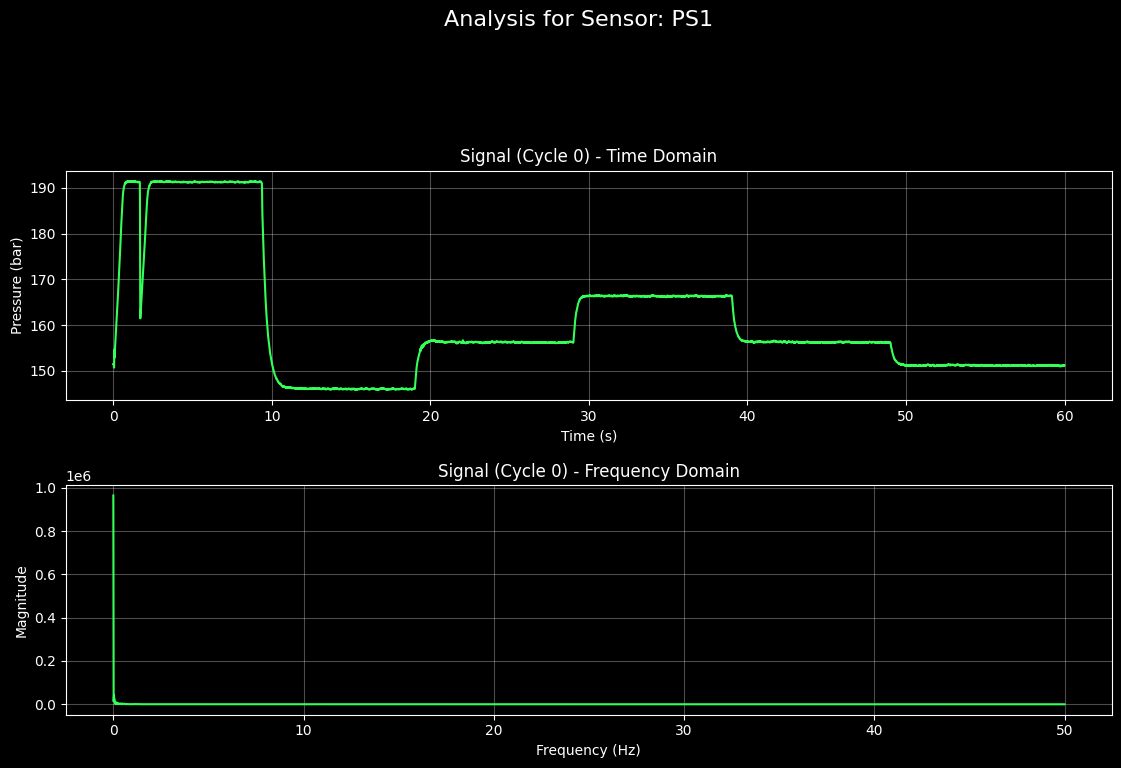

--- Processing Sensor: PS2 ---


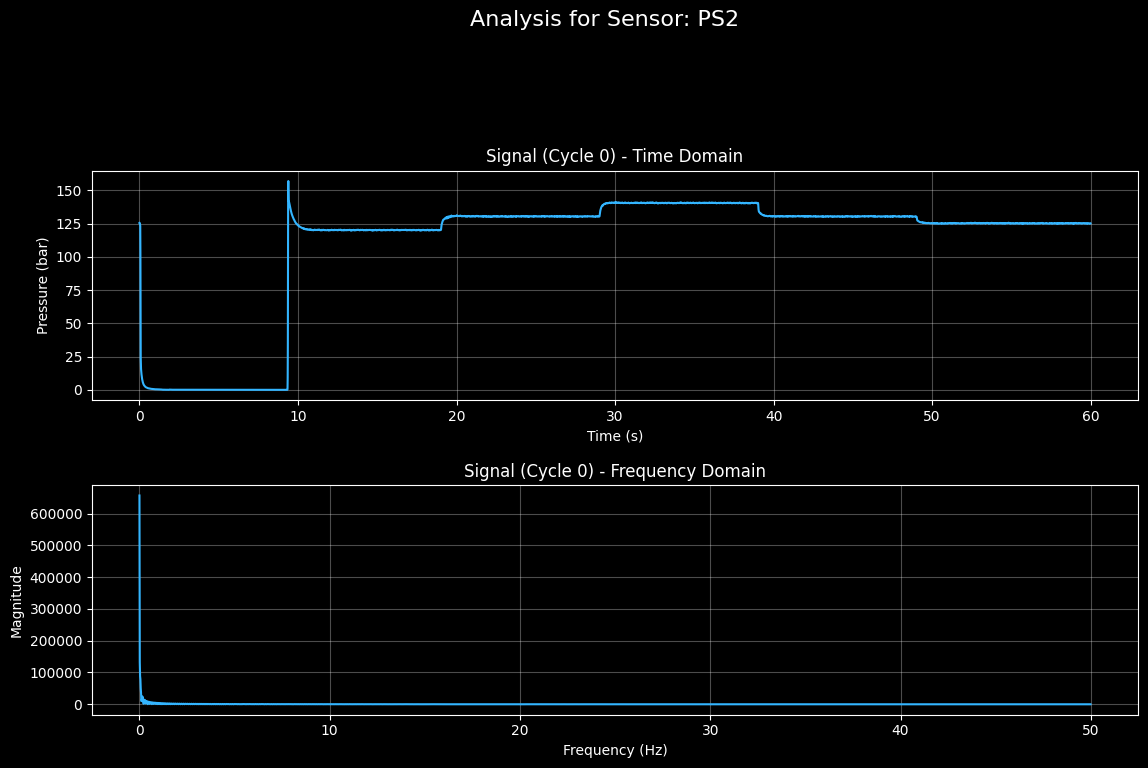

--- Processing Sensor: PS3 ---


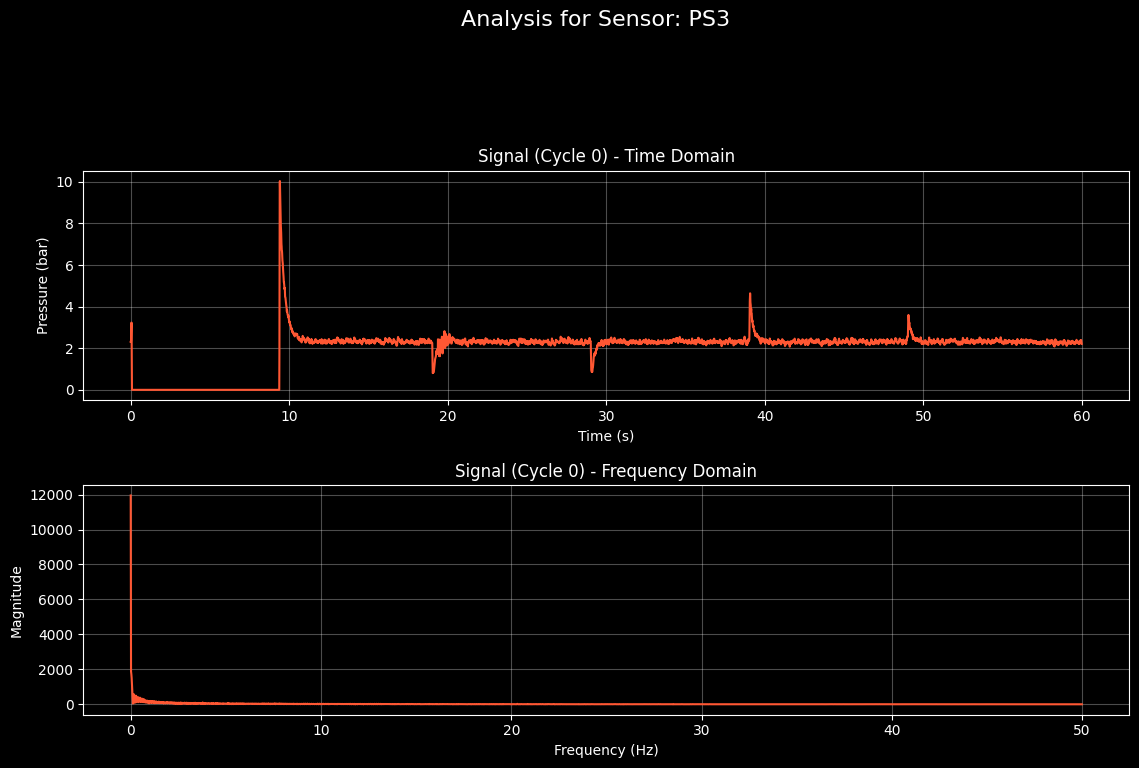

--- Processing Sensor: PS4 ---


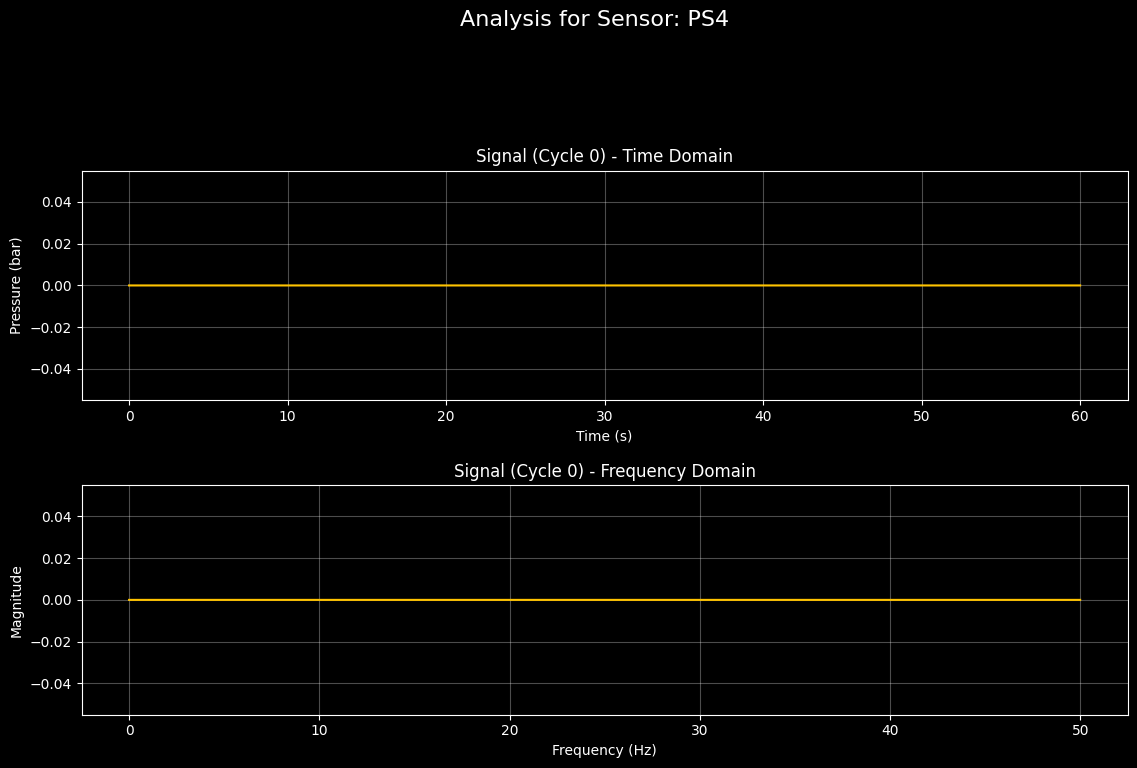

--- Processing Sensor: PS5 ---


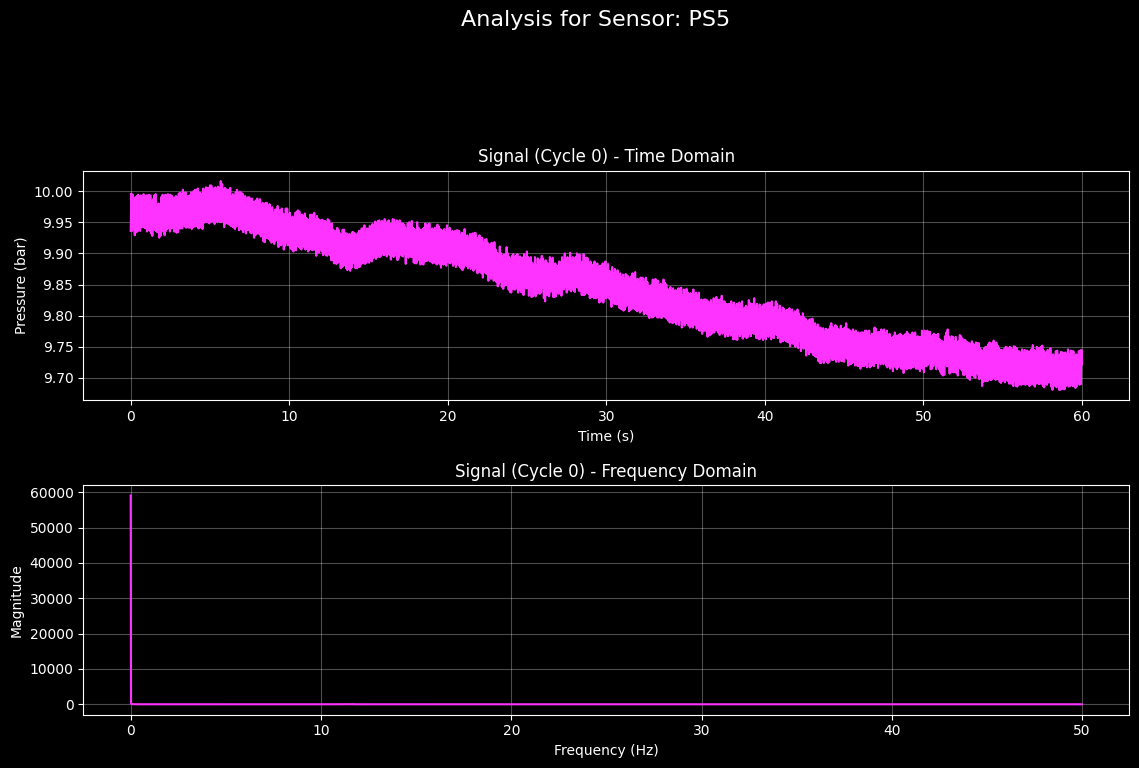

--- Processing Sensor: PS6 ---


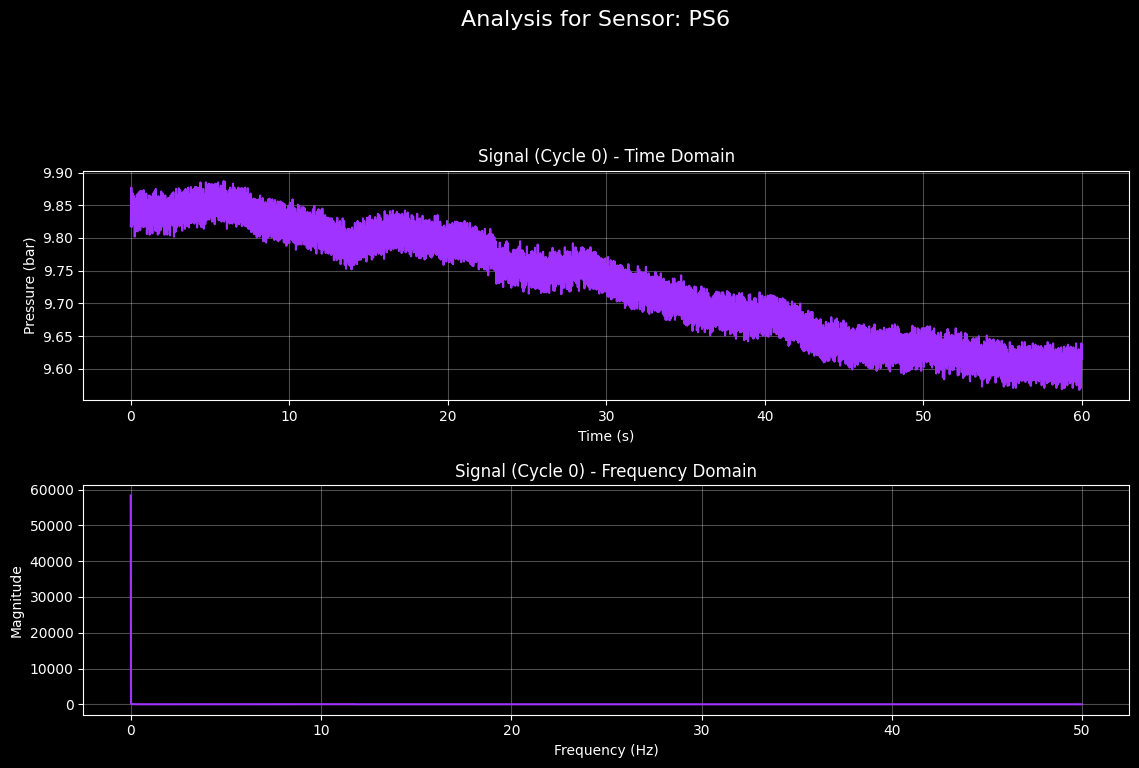

In [16]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# This assumes DATA_DIR is defined as in your notebook.
output_file = DATA_DIR + 'hydraulic_dataset.h5'

# List of pressure sensors to plot
pressure_sensors = ['PS1', 'PS2', 'PS3', 'PS4', 'PS5', 'PS6']

# Define a list of vibrant colors for plotting on a dark background
plot_colors = ['#33FF57', '#33B5FF', '#FF5733', '#FFC300', '#FF33FF', '#A033FF']
# (Lime Green, Bright Blue, Orange-Red, Vivid Yellow, Magenta, Bright Purple)

with h5py.File(output_file, 'r') as h5f:
    # Get sensor metadata once
    sensor_names = [name.decode('utf-8') for name in h5f['/metadata/sensor_names'][:]]
    sampling_rates = h5f['/metadata/sampling_rate'][:]
    sensor_sampling_rates = {name: rate for name, rate in zip(sensor_names, sampling_rates)}

    # --- Loop through each pressure sensor with an index for color selection ---
    for i, sensor in enumerate(pressure_sensors):
        print(f"--- Processing Sensor: {sensor} ---")

        # Select the color for the current sensor
        current_color = plot_colors[i]

        # Load the data for the current sensor
        sensor_data = h5f[f'/raw/{sensor}'][:]

        # Select the first cycle to analyze
        cycle_index = 0
        single_cycle_data = sensor_data[cycle_index]

        # Get the sampling rate
        fs = sensor_sampling_rates[sensor]
        N = len(single_cycle_data)

        # Perform the FFT
        yf = np.fft.fft(single_cycle_data)
        xf = np.fft.fftfreq(N, 1 / fs)

        # Get the positive half of the spectrum
        yf_magnitude = np.abs(yf[:N//2])
        xf_positive = xf[:N//2]

        # --- Plotting for the current sensor ---
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
        fig.suptitle(f'Analysis for Sensor: {sensor}', fontsize=16)
        fig.tight_layout(pad=4.0, rect=[0, 0, 1, 0.95])

        # Plot 1: Time Domain Signal
        time_vector = np.arange(N) / fs
        # Use the specified color for the plot
        ax1.plot(time_vector, single_cycle_data, color=current_color)
        ax1.set_title(f'Signal (Cycle {cycle_index}) - Time Domain')
        ax1.set_xlabel('Time (s)')
        ax1.set_ylabel('Pressure (bar)')
        ax1.grid(True, alpha=0.3)

        # Plot 2: Frequency Domain Signal (Spectrum)
        # Use the same color for consistency
        ax2.plot(xf_positive, yf_magnitude, color=current_color)
        ax2.set_title(f'Signal (Cycle {cycle_index}) - Frequency Domain')
        ax2.set_xlabel('Frequency (Hz)')
        ax2.set_ylabel('Magnitude')
        ax2.grid(True, alpha=0.3)

        plt.show()

--- Processing Sensor: TS1 ---


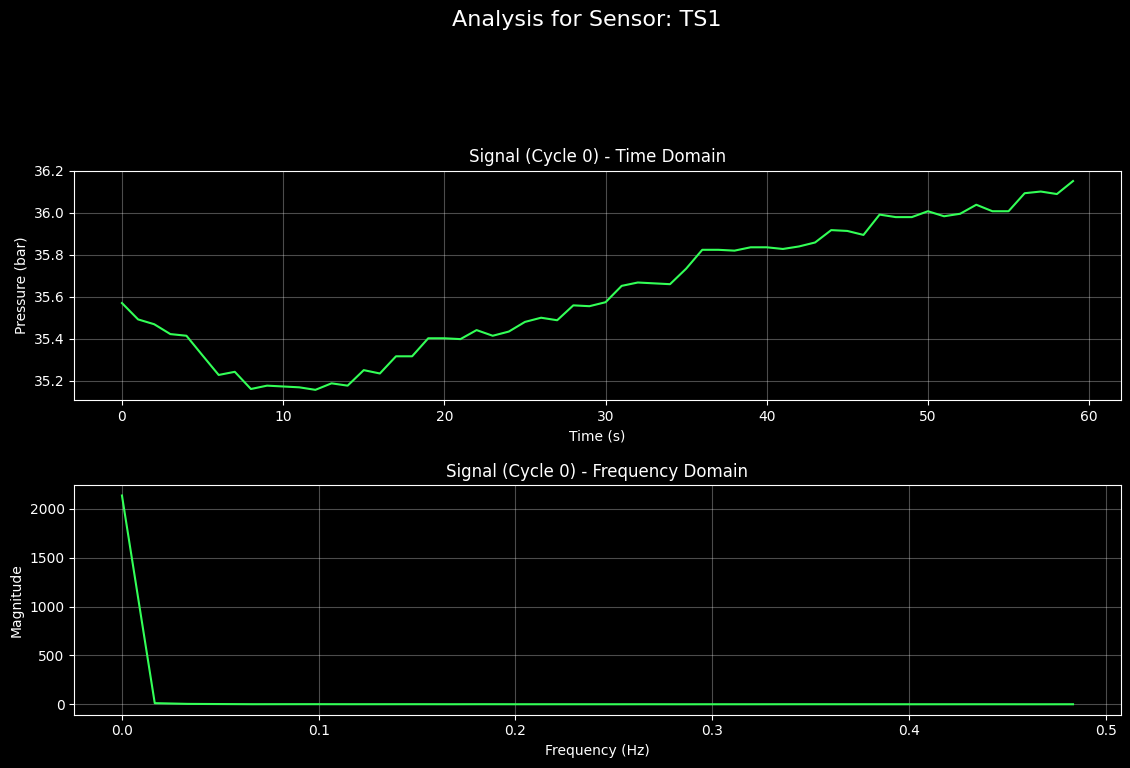

--- Processing Sensor: TS2 ---


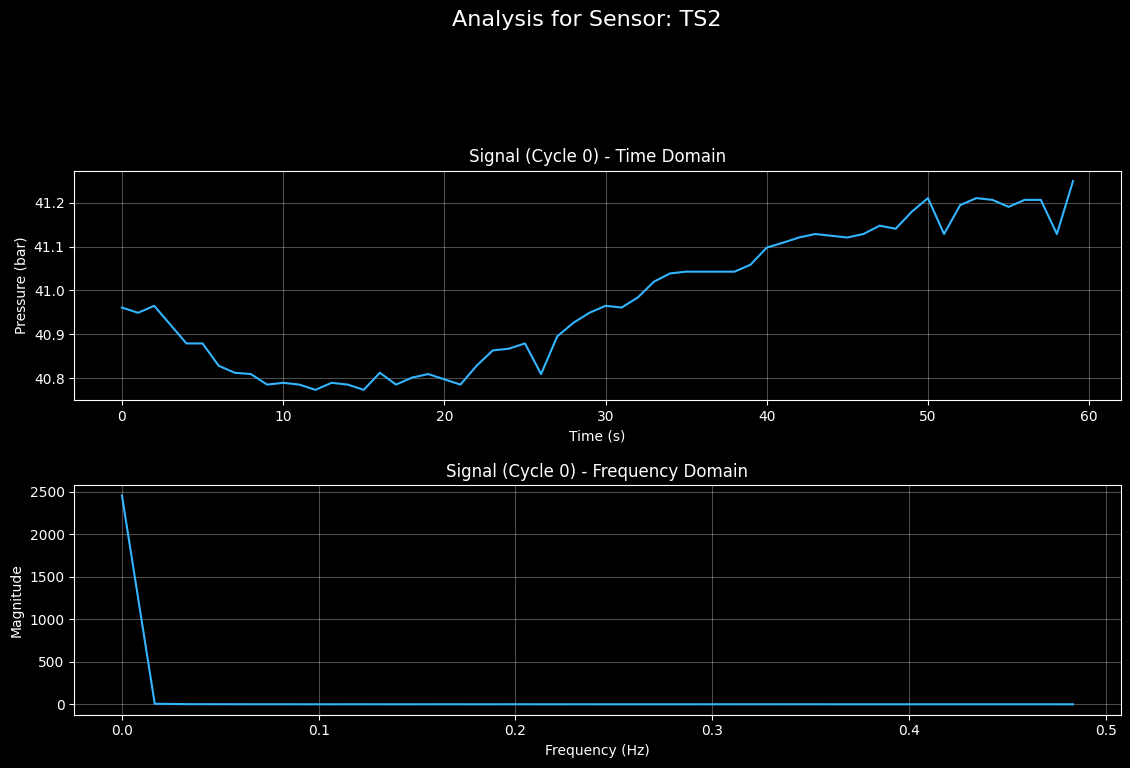

--- Processing Sensor: TS3 ---


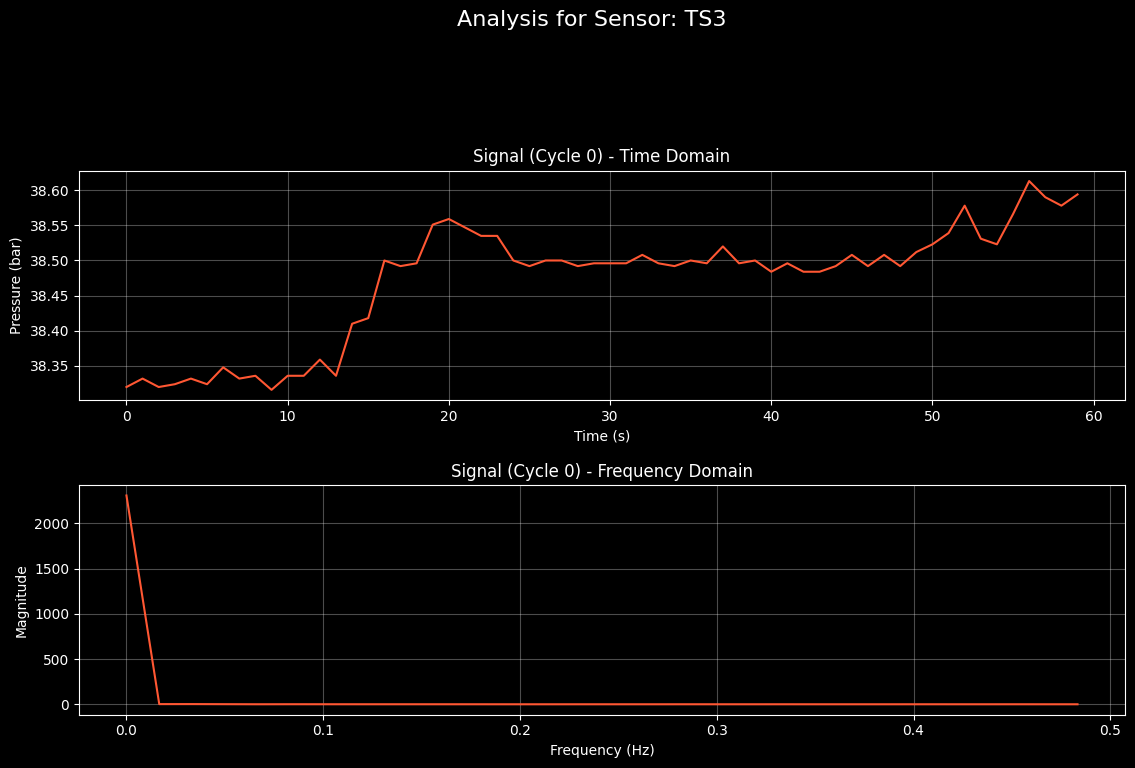

--- Processing Sensor: TS4 ---


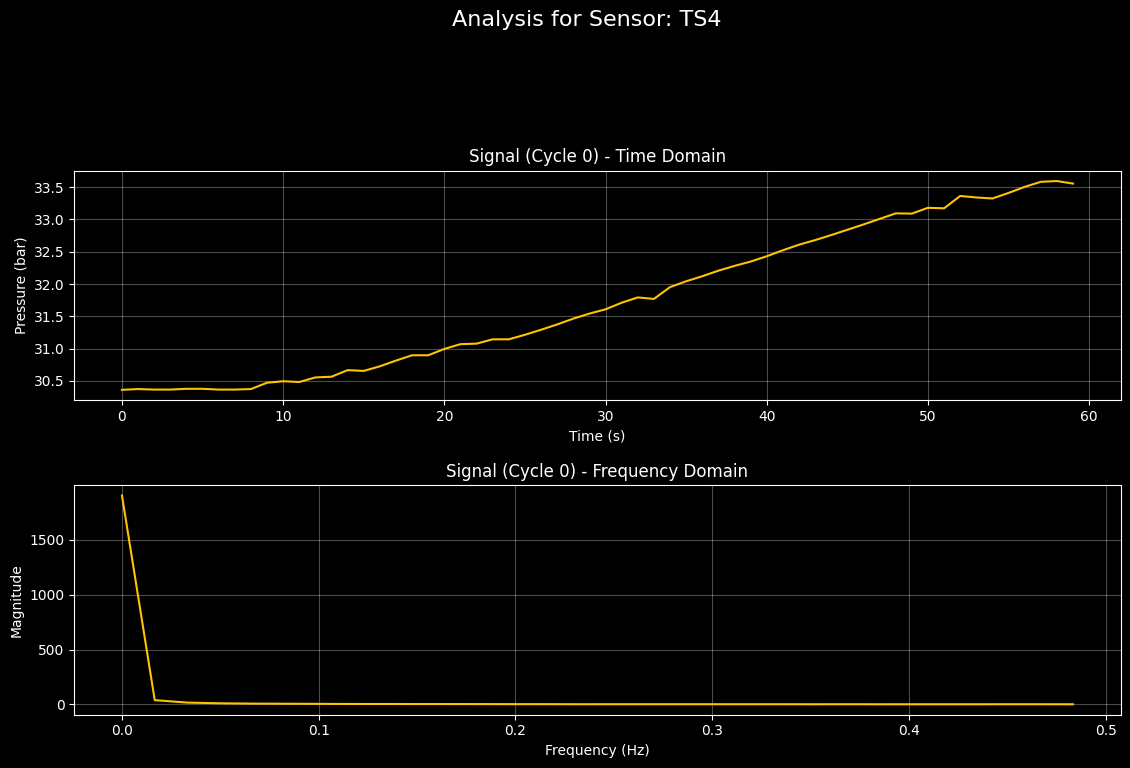

In [17]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# This assumes DATA_DIR is defined as in your notebook.
output_file = DATA_DIR + 'hydraulic_dataset.h5'

# List of pressure sensors to plot
pressure_sensors = ['TS1', 'TS2', 'TS3', 'TS4']

# Define a list of vibrant colors for plotting on a dark background
plot_colors = ['#33FF57', '#33B5FF', '#FF5733', '#FFC300', '#FF33FF', '#A033FF']
# (Lime Green, Bright Blue, Orange-Red, Vivid Yellow, Magenta, Bright Purple)

with h5py.File(output_file, 'r') as h5f:
    # Get sensor metadata once
    sensor_names = [name.decode('utf-8') for name in h5f['/metadata/sensor_names'][:]]
    sampling_rates = h5f['/metadata/sampling_rate'][:]
    sensor_sampling_rates = {name: rate for name, rate in zip(sensor_names, sampling_rates)}

    # --- Loop through each pressure sensor with an index for color selection ---
    for i, sensor in enumerate(pressure_sensors):
        print(f"--- Processing Sensor: {sensor} ---")

        # Select the color for the current sensor
        current_color = plot_colors[i]

        # Load the data for the current sensor
        sensor_data = h5f[f'/raw/{sensor}'][:]

        # Select the first cycle to analyze
        cycle_index = 0
        single_cycle_data = sensor_data[cycle_index]

        # Get the sampling rate
        fs = sensor_sampling_rates[sensor]
        N = len(single_cycle_data)

        # Perform the FFT
        yf = np.fft.fft(single_cycle_data)
        xf = np.fft.fftfreq(N, 1 / fs)

        # Get the positive half of the spectrum
        yf_magnitude = np.abs(yf[:N//2])
        xf_positive = xf[:N//2]

        # --- Plotting for the current sensor ---
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
        fig.suptitle(f'Analysis for Sensor: {sensor}', fontsize=16)
        fig.tight_layout(pad=4.0, rect=[0, 0, 1, 0.95])

        # Plot 1: Time Domain Signal
        time_vector = np.arange(N) / fs
        # Use the specified color for the plot
        ax1.plot(time_vector, single_cycle_data, color=current_color)
        ax1.set_title(f'Signal (Cycle {cycle_index}) - Time Domain')
        ax1.set_xlabel('Time (s)')
        ax1.set_ylabel('Pressure (bar)')
        ax1.grid(True, alpha=0.3)

        # Plot 2: Frequency Domain Signal (Spectrum)
        # Use the same color for consistency
        ax2.plot(xf_positive, yf_magnitude, color=current_color)
        ax2.set_title(f'Signal (Cycle {cycle_index}) - Frequency Domain')
        ax2.set_xlabel('Frequency (Hz)')
        ax2.set_ylabel('Magnitude')
        ax2.grid(True, alpha=0.3)

        plt.show()

--- Processing Sensor: FS1 ---


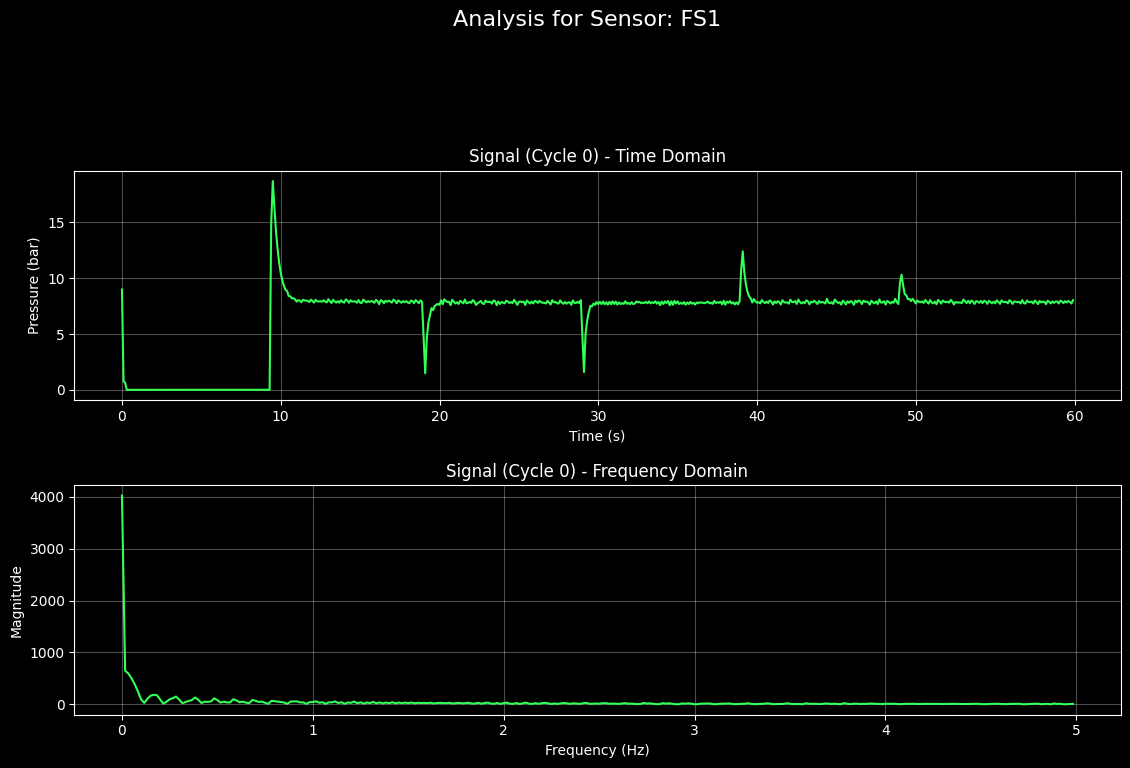

--- Processing Sensor: FS2 ---


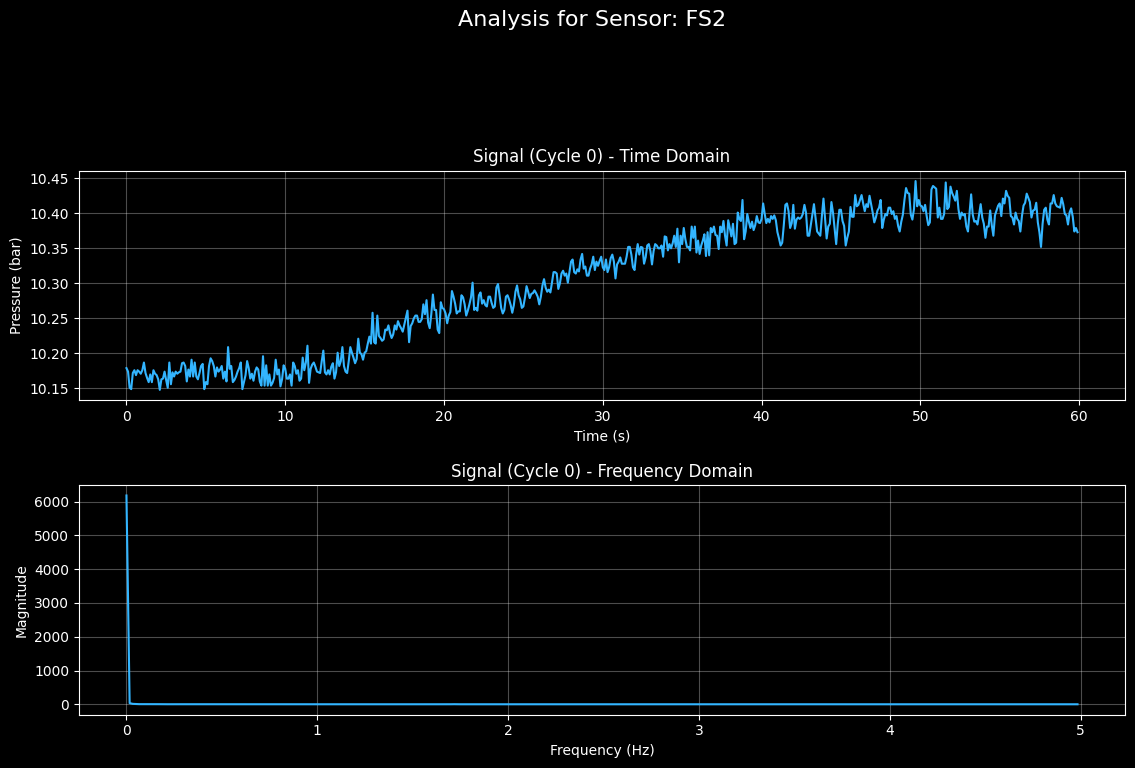

In [18]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# This assumes DATA_DIR is defined as in your notebook.
output_file = DATA_DIR + 'hydraulic_dataset.h5'

# List of pressure sensors to plot
pressure_sensors = ['FS1', 'FS2']

# Define a list of vibrant colors for plotting on a dark background
plot_colors = ['#33FF57', '#33B5FF', '#FF5733', '#FFC300', '#FF33FF', '#A033FF']
# (Lime Green, Bright Blue, Orange-Red, Vivid Yellow, Magenta, Bright Purple)

with h5py.File(output_file, 'r') as h5f:
    # Get sensor metadata once
    sensor_names = [name.decode('utf-8') for name in h5f['/metadata/sensor_names'][:]]
    sampling_rates = h5f['/metadata/sampling_rate'][:]
    sensor_sampling_rates = {name: rate for name, rate in zip(sensor_names, sampling_rates)}

    # --- Loop through each pressure sensor with an index for color selection ---
    for i, sensor in enumerate(pressure_sensors):
        print(f"--- Processing Sensor: {sensor} ---")

        # Select the color for the current sensor
        current_color = plot_colors[i]

        # Load the data for the current sensor
        sensor_data = h5f[f'/raw/{sensor}'][:]

        # Select the first cycle to analyze
        cycle_index = 0
        single_cycle_data = sensor_data[cycle_index]

        # Get the sampling rate
        fs = sensor_sampling_rates[sensor]
        N = len(single_cycle_data)

        # Perform the FFT
        yf = np.fft.fft(single_cycle_data)
        xf = np.fft.fftfreq(N, 1 / fs)

        # Get the positive half of the spectrum
        yf_magnitude = np.abs(yf[:N//2])
        xf_positive = xf[:N//2]

        # --- Plotting for the current sensor ---
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
        fig.suptitle(f'Analysis for Sensor: {sensor}', fontsize=16)
        fig.tight_layout(pad=4.0, rect=[0, 0, 1, 0.95])

        # Plot 1: Time Domain Signal
        time_vector = np.arange(N) / fs
        # Use the specified color for the plot
        ax1.plot(time_vector, single_cycle_data, color=current_color)
        ax1.set_title(f'Signal (Cycle {cycle_index}) - Time Domain')
        ax1.set_xlabel('Time (s)')
        ax1.set_ylabel('Pressure (bar)')
        ax1.grid(True, alpha=0.3)

        # Plot 2: Frequency Domain Signal (Spectrum)
        # Use the same color for consistency
        ax2.plot(xf_positive, yf_magnitude, color=current_color)
        ax2.set_title(f'Signal (Cycle {cycle_index}) - Frequency Domain')
        ax2.set_xlabel('Frequency (Hz)')
        ax2.set_ylabel('Magnitude')
        ax2.grid(True, alpha=0.3)

        plt.show()

--- Processing Sensor: EPS1 ---


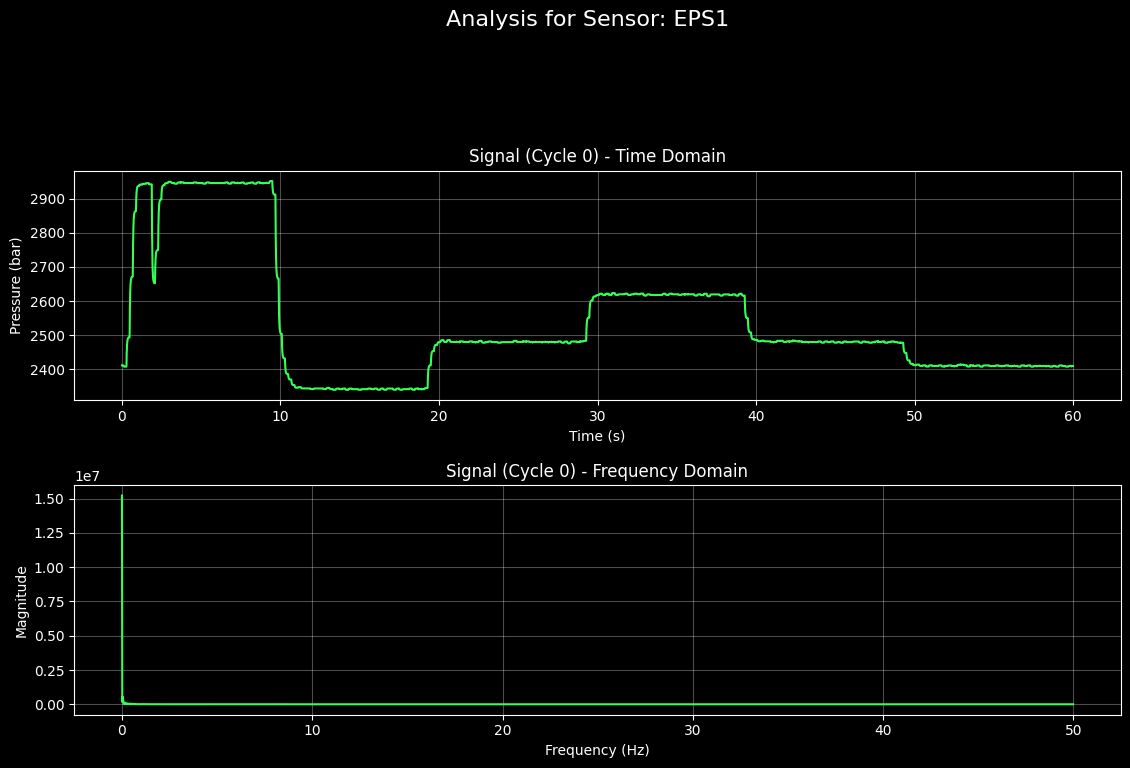

In [20]:

import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# This assumes DATA_DIR is defined as in your notebook.
output_file = DATA_DIR + 'hydraulic_dataset.h5'

# List of pressure sensors to plot
pressure_sensors = ['EPS1']

# Define a list of vibrant colors for plotting on a dark background
plot_colors = ['#33FF57', '#33B5FF', '#FF5733', '#FFC300', '#FF33FF', '#A033FF']
# (Lime Green, Bright Blue, Orange-Red, Vivid Yellow, Magenta, Bright Purple)

with h5py.File(output_file, 'r') as h5f:
    # Get sensor metadata once
    sensor_names = [name.decode('utf-8') for name in h5f['/metadata/sensor_names'][:]]
    sampling_rates = h5f['/metadata/sampling_rate'][:]
    sensor_sampling_rates = {name: rate for name, rate in zip(sensor_names, sampling_rates)}

    # --- Loop through each pressure sensor with an index for color selection ---
    for i, sensor in enumerate(pressure_sensors):
        print(f"--- Processing Sensor: {sensor} ---")

        # Select the color for the current sensor
        current_color = plot_colors[i]

        # Load the data for the current sensor
        sensor_data = h5f[f'/raw/{sensor}'][:]

        # Select the first cycle to analyze
        cycle_index = 0
        single_cycle_data = sensor_data[cycle_index]

        # Get the sampling rate
        fs = sensor_sampling_rates[sensor]
        N = len(single_cycle_data)

        # Perform the FFT
        yf = np.fft.fft(single_cycle_data)
        xf = np.fft.fftfreq(N, 1 / fs)

        # Get the positive half of the spectrum
        yf_magnitude = np.abs(yf[:N//2])
        xf_positive = xf[:N//2]

        # --- Plotting for the current sensor ---
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
        fig.suptitle(f'Analysis for Sensor: {sensor}', fontsize=16)
        fig.tight_layout(pad=4.0, rect=[0, 0, 1, 0.95])

        # Plot 1: Time Domain Signal
        time_vector = np.arange(N) / fs
        # Use the specified color for the plot
        ax1.plot(time_vector, single_cycle_data, color=current_color)
        ax1.set_title(f'Signal (Cycle {cycle_index}) - Time Domain')
        ax1.set_xlabel('Time (s)')
        ax1.set_ylabel('Pressure (bar)')
        ax1.grid(True, alpha=0.3)

        # Plot 2: Frequency Domain Signal (Spectrum)
        # Use the same color for consistency
        ax2.plot(xf_positive, yf_magnitude, color=current_color)
        ax2.set_title(f'Signal (Cycle {cycle_index}) - Frequency Domain')
        ax2.set_xlabel('Frequency (Hz)')
        ax2.set_ylabel('Magnitude')
        ax2.grid(True, alpha=0.3)

        plt.show()

--- Processing Sensor: VS1 ---


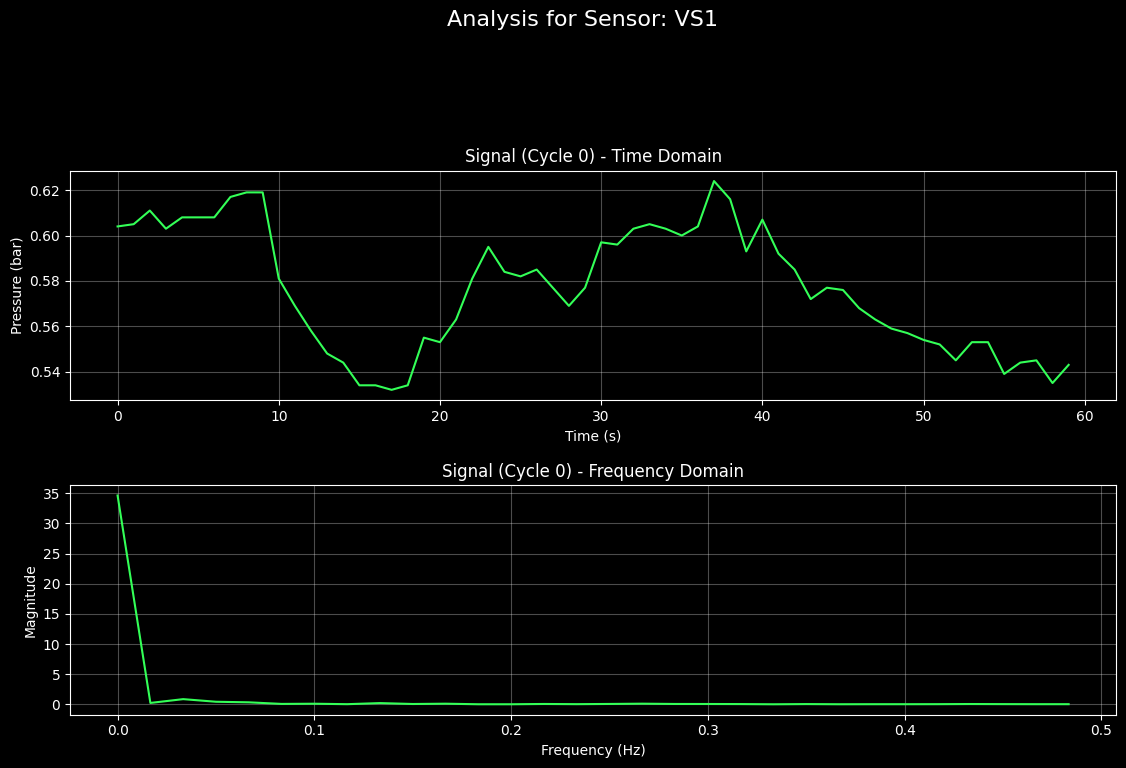

In [21]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# This assumes DATA_DIR is defined as in your notebook.
output_file = DATA_DIR + 'hydraulic_dataset.h5'

# List of pressure sensors to plot
pressure_sensors = ['VS1']

# Define a list of vibrant colors for plotting on a dark background
plot_colors = ['#33FF57', '#33B5FF', '#FF5733', '#FFC300', '#FF33FF', '#A033FF']
# (Lime Green, Bright Blue, Orange-Red, Vivid Yellow, Magenta, Bright Purple)

with h5py.File(output_file, 'r') as h5f:
    # Get sensor metadata once
    sensor_names = [name.decode('utf-8') for name in h5f['/metadata/sensor_names'][:]]
    sampling_rates = h5f['/metadata/sampling_rate'][:]
    sensor_sampling_rates = {name: rate for name, rate in zip(sensor_names, sampling_rates)}

    # --- Loop through each pressure sensor with an index for color selection ---
    for i, sensor in enumerate(pressure_sensors):
        print(f"--- Processing Sensor: {sensor} ---")

        # Select the color for the current sensor
        current_color = plot_colors[i]

        # Load the data for the current sensor
        sensor_data = h5f[f'/raw/{sensor}'][:]

        # Select the first cycle to analyze
        cycle_index = 0
        single_cycle_data = sensor_data[cycle_index]

        # Get the sampling rate
        fs = sensor_sampling_rates[sensor]
        N = len(single_cycle_data)

        # Perform the FFT
        yf = np.fft.fft(single_cycle_data)
        xf = np.fft.fftfreq(N, 1 / fs)

        # Get the positive half of the spectrum
        yf_magnitude = np.abs(yf[:N//2])
        xf_positive = xf[:N//2]

        # --- Plotting for the current sensor ---
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
        fig.suptitle(f'Analysis for Sensor: {sensor}', fontsize=16)
        fig.tight_layout(pad=4.0, rect=[0, 0, 1, 0.95])

        # Plot 1: Time Domain Signal
        time_vector = np.arange(N) / fs
        # Use the specified color for the plot
        ax1.plot(time_vector, single_cycle_data, color=current_color)
        ax1.set_title(f'Signal (Cycle {cycle_index}) - Time Domain')
        ax1.set_xlabel('Time (s)')
        ax1.set_ylabel('Pressure (bar)')
        ax1.grid(True, alpha=0.3)

        # Plot 2: Frequency Domain Signal (Spectrum)
        # Use the same color for consistency
        ax2.plot(xf_positive, yf_magnitude, color=current_color)
        ax2.set_title(f'Signal (Cycle {cycle_index}) - Frequency Domain')
        ax2.set_xlabel('Frequency (Hz)')
        ax2.set_ylabel('Magnitude')
        ax2.grid(True, alpha=0.3)

        plt.show()

--- Processing Sensor: CE ---


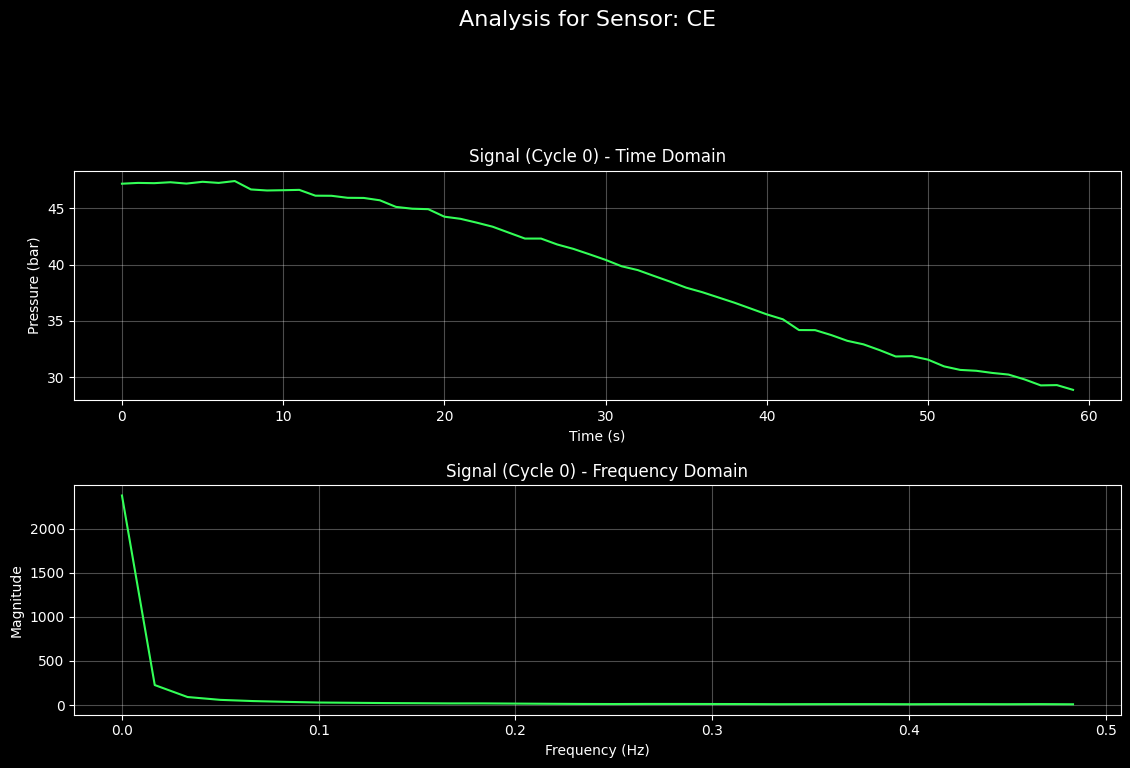

In [20]:

import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# This assumes DATA_DIR is defined as in your notebook.
output_file = DATA_DIR + 'hydraulic_dataset.h5'

# List of pressure sensors to plot
pressure_sensors = ['CE']

# Define a list of vibrant colors for plotting on a dark background
plot_colors = ['#33FF57', '#33B5FF', '#FF5733', '#FFC300', '#FF33FF', '#A033FF']
# (Lime Green, Bright Blue, Orange-Red, Vivid Yellow, Magenta, Bright Purple)

with h5py.File(output_file, 'r') as h5f:
    # Get sensor metadata once
    sensor_names = [name.decode('utf-8') for name in h5f['/metadata/sensor_names'][:]]
    sampling_rates = h5f['/metadata/sampling_rate'][:]
    sensor_sampling_rates = {name: rate for name, rate in zip(sensor_names, sampling_rates)}

    # --- Loop through each pressure sensor with an index for color selection ---
    for i, sensor in enumerate(pressure_sensors):
        print(f"--- Processing Sensor: {sensor} ---")

        # Select the color for the current sensor
        current_color = plot_colors[i]

        # Load the data for the current sensor
        sensor_data = h5f[f'/raw/{sensor}'][:]

        # Select the first cycle to analyze
        cycle_index = 0
        single_cycle_data = sensor_data[cycle_index]

        # Get the sampling rate
        fs = sensor_sampling_rates[sensor]
        N = len(single_cycle_data)

        # Perform the FFT
        yf = np.fft.fft(single_cycle_data)
        xf = np.fft.fftfreq(N, 1 / fs)

        # Get the positive half of the spectrum
        yf_magnitude = np.abs(yf[:N//2])
        xf_positive = xf[:N//2]

        # --- Plotting for the current sensor ---
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
        fig.suptitle(f'Analysis for Sensor: {sensor}', fontsize=16)
        fig.tight_layout(pad=4.0, rect=[0, 0, 1, 0.95])

        # Plot 1: Time Domain Signal
        time_vector = np.arange(N) / fs
        # Use the specified color for the plot
        ax1.plot(time_vector, single_cycle_data, color=current_color)
        ax1.set_title(f'Signal (Cycle {cycle_index}) - Time Domain')
        ax1.set_xlabel('Time (s)')
        ax1.set_ylabel('Pressure (bar)')
        ax1.grid(True, alpha=0.3)

        # Plot 2: Frequency Domain Signal (Spectrum)
        # Use the same color for consistency
        ax2.plot(xf_positive, yf_magnitude, color=current_color)
        ax2.set_title(f'Signal (Cycle {cycle_index}) - Frequency Domain')
        ax2.set_xlabel('Frequency (Hz)')
        ax2.set_ylabel('Magnitude')
        ax2.grid(True, alpha=0.3)

        plt.show()

--- Processing Sensor: CP ---


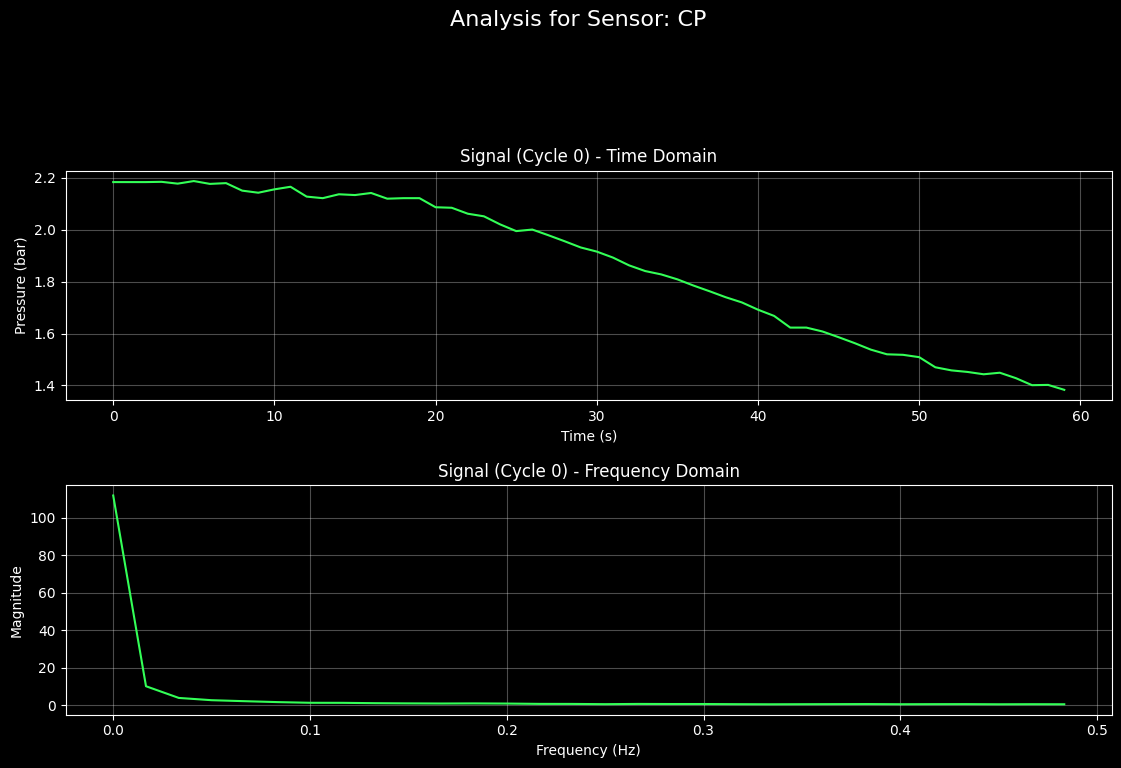

In [22]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# This assumes DATA_DIR is defined as in your notebook.
output_file = DATA_DIR + 'hydraulic_dataset.h5'

# List of pressure sensors to plot
pressure_sensors = ['CP']

# Define a list of vibrant colors for plotting on a dark background
plot_colors = ['#33FF57', '#33B5FF', '#FF5733', '#FFC300', '#FF33FF', '#A033FF']
# (Lime Green, Bright Blue, Orange-Red, Vivid Yellow, Magenta, Bright Purple)

with h5py.File(output_file, 'r') as h5f:
    # Get sensor metadata once
    sensor_names = [name.decode('utf-8') for name in h5f['/metadata/sensor_names'][:]]
    sampling_rates = h5f['/metadata/sampling_rate'][:]
    sensor_sampling_rates = {name: rate for name, rate in zip(sensor_names, sampling_rates)}

    # --- Loop through each pressure sensor with an index for color selection ---
    for i, sensor in enumerate(pressure_sensors):
        print(f"--- Processing Sensor: {sensor} ---")

        # Select the color for the current sensor
        current_color = plot_colors[i]

        # Load the data for the current sensor
        sensor_data = h5f[f'/raw/{sensor}'][:]

        # Select the first cycle to analyze
        cycle_index = 0
        single_cycle_data = sensor_data[cycle_index]

        # Get the sampling rate
        fs = sensor_sampling_rates[sensor]
        N = len(single_cycle_data)

        # Perform the FFT
        yf = np.fft.fft(single_cycle_data)
        xf = np.fft.fftfreq(N, 1 / fs)

        # Get the positive half of the spectrum
        yf_magnitude = np.abs(yf[:N//2])
        xf_positive = xf[:N//2]

        # --- Plotting for the current sensor ---
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
        fig.suptitle(f'Analysis for Sensor: {sensor}', fontsize=16)
        fig.tight_layout(pad=4.0, rect=[0, 0, 1, 0.95])

        # Plot 1: Time Domain Signal
        time_vector = np.arange(N) / fs
        # Use the specified color for the plot
        ax1.plot(time_vector, single_cycle_data, color=current_color)
        ax1.set_title(f'Signal (Cycle {cycle_index}) - Time Domain')
        ax1.set_xlabel('Time (s)')
        ax1.set_ylabel('Pressure (bar)')
        ax1.grid(True, alpha=0.3)

        # Plot 2: Frequency Domain Signal (Spectrum)
        # Use the same color for consistency
        ax2.plot(xf_positive, yf_magnitude, color=current_color)
        ax2.set_title(f'Signal (Cycle {cycle_index}) - Frequency Domain')
        ax2.set_xlabel('Frequency (Hz)')
        ax2.set_ylabel('Magnitude')
        ax2.grid(True, alpha=0.3)

        plt.show()

--- Processing Sensor: SE ---


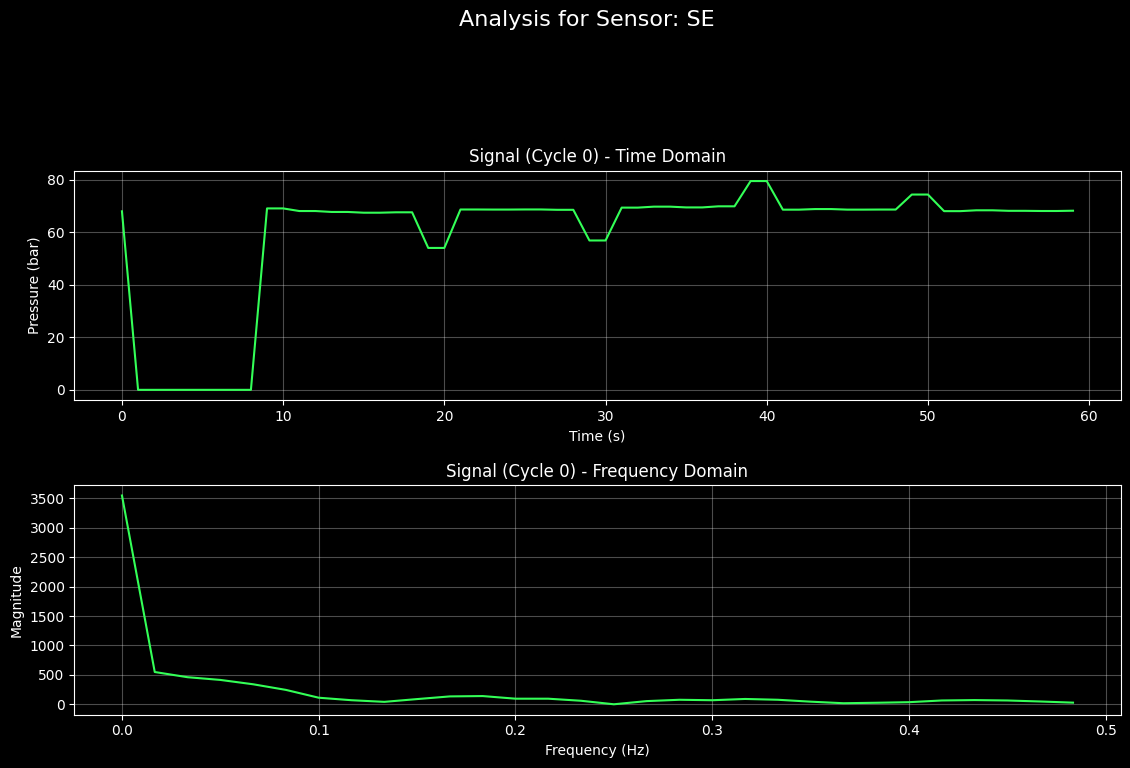

In [23]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# This assumes DATA_DIR is defined as in your notebook.
output_file = DATA_DIR + 'hydraulic_dataset.h5'

# List of pressure sensors to plot
pressure_sensors = ['SE']

# Define a list of vibrant colors for plotting on a dark background
plot_colors = ['#33FF57', '#33B5FF', '#FF5733', '#FFC300', '#FF33FF', '#A033FF']
# (Lime Green, Bright Blue, Orange-Red, Vivid Yellow, Magenta, Bright Purple)

with h5py.File(output_file, 'r') as h5f:
    # Get sensor metadata once
    sensor_names = [name.decode('utf-8') for name in h5f['/metadata/sensor_names'][:]]
    sampling_rates = h5f['/metadata/sampling_rate'][:]
    sensor_sampling_rates = {name: rate for name, rate in zip(sensor_names, sampling_rates)}

    # --- Loop through each pressure sensor with an index for color selection ---
    for i, sensor in enumerate(pressure_sensors):
        print(f"--- Processing Sensor: {sensor} ---")

        # Select the color for the current sensor
        current_color = plot_colors[i]

        # Load the data for the current sensor
        sensor_data = h5f[f'/raw/{sensor}'][:]

        # Select the first cycle to analyze
        cycle_index = 0
        single_cycle_data = sensor_data[cycle_index]

        # Get the sampling rate
        fs = sensor_sampling_rates[sensor]
        N = len(single_cycle_data)

        # Perform the FFT
        yf = np.fft.fft(single_cycle_data)
        xf = np.fft.fftfreq(N, 1 / fs)

        # Get the positive half of the spectrum
        yf_magnitude = np.abs(yf[:N//2])
        xf_positive = xf[:N//2]

        # --- Plotting for the current sensor ---
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
        fig.suptitle(f'Analysis for Sensor: {sensor}', fontsize=16)
        fig.tight_layout(pad=4.0, rect=[0, 0, 1, 0.95])

        # Plot 1: Time Domain Signal
        time_vector = np.arange(N) / fs
        # Use the specified color for the plot
        ax1.plot(time_vector, single_cycle_data, color=current_color)
        ax1.set_title(f'Signal (Cycle {cycle_index}) - Time Domain')
        ax1.set_xlabel('Time (s)')
        ax1.set_ylabel('Pressure (bar)')
        ax1.grid(True, alpha=0.3)

        # Plot 2: Frequency Domain Signal (Spectrum)
        # Use the same color for consistency
        ax2.plot(xf_positive, yf_magnitude, color=current_color)
        ax2.set_title(f'Signal (Cycle {cycle_index}) - Frequency Domain')
        ax2.set_xlabel('Frequency (Hz)')
        ax2.set_ylabel('Magnitude')
        ax2.grid(True, alpha=0.3)

        plt.show()

In [24]:
import h5py
import numpy as np
import pandas as pd
 
# This assumes DATA_DIR is defined as in your notebook.
output_file = DATA_DIR + 'hydraulic_dataset.h5'
 
# The extract_fft_features function from before
def extract_fft_features(signal, sampling_rate, num_peaks=5):
    N = len(signal)
    yf = np.fft.fft(signal)
    xf = np.fft.fftfreq(N, 1 / sampling_rate)
    yf_magnitude = np.abs(yf[:N//2])
    xf_positive = xf[:N//2]
    features = {}
    features['fft_mean'] = np.mean(yf_magnitude)
    features['fft_std'] = np.std(yf_magnitude)
    features['fft_max'] = np.max(yf_magnitude)
    peak_indices = np.argpartition(yf_magnitude, -num_peaks)[-num_peaks:]
    sorted_peak_indices = peak_indices[np.argsort(yf_magnitude[peak_indices])][::-1]
    for i in range(num_peaks):
        peak_idx = sorted_peak_indices[i]
        features[f'peak_freq_{i+1}'] = xf_positive[peak_idx]
        features[f'peak_mag_{i+1}'] = yf_magnitude[peak_idx]
    return features
 
# --- Main Feature Extraction for All Sensors ---
 
# The full list of sensors you want to process
all_sensor_names = ['PS1', 'PS2', 'PS3', 'PS4', 'PS5', 'PS6', 'EPS1', 'FS1', 'FS2', 
                    'TS1', 'TS2', 'TS3', 'TS4', 'VS1', 'CE', 'CP', 'SE']
 
# A list to hold each sensor's feature DataFrame
all_sensor_feature_dfs = []
 
with h5py.File(output_file, 'r') as h5f:
    # Get sensor metadata once
    sensor_names_meta = [name.decode('utf-8') for name in h5f['/metadata/sensor_names'][:]]
    sampling_rates = h5f['/metadata/sampling_rate'][:]
    sensor_sampling_rates = {name: rate for name, rate in zip(sensor_names_meta, sampling_rates)}
 
    # Loop over every sensor name
    for sensor_name in all_sensor_names:
        print(f"Extracting features for sensor: {sensor_name}...")
        # Load data for the current sensor
        sensor_data = h5f[f'/raw/{sensor_name}'][:]
        fs = sensor_sampling_rates[sensor_name]
        # Extract features for every cycle of this sensor
        all_cycle_features = []
        for i in range(sensor_data.shape[0]):
            cycle_data = sensor_data[i]
            features = extract_fft_features(cycle_data, fs, num_peaks=5)
            all_cycle_features.append(features)
        # Create a DataFrame for the current sensor's features
        df_temp_features = pd.DataFrame(all_cycle_features)
        # IMPORTANT: Rename columns to be specific to this sensor
        df_temp_features = df_temp_features.add_prefix(f'{sensor_name}_')
        # Add the sensor-specific DataFrame to our list
        all_sensor_feature_dfs.append(df_temp_features)
 
# Concatenate all the individual DataFrames into one big DataFrame
df_all_features = pd.concat(all_sensor_feature_dfs, axis=1)
 
print("\n--- Feature Extraction Complete ---")
print("Shape of the final combined feature DataFrame:", df_all_features.shape)
print("First 5 rows of the final feature DataFrame:")
display(df_all_features.head())

Extracting features for sensor: PS1...
Extracting features for sensor: PS2...
Extracting features for sensor: PS3...
Extracting features for sensor: PS4...
Extracting features for sensor: PS5...
Extracting features for sensor: PS6...
Extracting features for sensor: EPS1...
Extracting features for sensor: FS1...
Extracting features for sensor: FS2...
Extracting features for sensor: TS1...
Extracting features for sensor: TS2...
Extracting features for sensor: TS3...
Extracting features for sensor: TS4...
Extracting features for sensor: VS1...
Extracting features for sensor: CE...
Extracting features for sensor: CP...
Extracting features for sensor: SE...

--- Feature Extraction Complete ---
Shape of the final combined feature DataFrame: (2205, 221)
First 5 rows of the final feature DataFrame:


,PS1_fft_mean,PS1_fft_std,PS1_fft_max,PS1_peak_freq_1,PS1_peak_mag_1,PS1_peak_freq_2,PS1_peak_mag_2,PS1_peak_freq_3,PS1_peak_mag_3,PS1_peak_freq_4,...,SE_peak_freq_1,SE_peak_mag_1,SE_peak_freq_2,SE_peak_mag_2,SE_peak_freq_3,SE_peak_mag_3,SE_peak_freq_4,SE_peak_mag_4,SE_peak_freq_5,SE_peak_mag_5
0,428.836619,17628.765750,964040.95,0.0,964040.95,0.033333,41124.954872,0.05,25006.857544,0.066667,...,0.0,3549.431,0.016667,549.325209,0.033333,461.093339,0.05,414.805432,0.066667,340.830538
1,403.719649,17622.542362,963619.92,0.0,963619.92,0.033333,41688.033643,0.05,25491.721727,0.066667,...,0.0,3560.137,0.016667,562.590366,0.033333,465.026661,0.05,416.573933,0.066667,337.212180
2,404.036724,17594.937656,962086.32,0.0,962086.32,0.033333,41976.548343,0.05,25502.637064,0.066667,...,0.0,3572.589,0.016667,560.457045,0.033333,467.494335,0.05,414.941344,0.066667,341.463301
3,403.823455,17577.655992,961128.53,0.0,961128.53,0.033333,42046.830270,0.05,25568.205520,0.066667,...,0.0,3587.694,0.016667,557.762659,0.033333,464.853532,0.05,422.323211,0.066667,345.164357
4,404.176790,17557.367340,960002.83,0.0,960002.83,0.033333,42147.319629,0.05,25634.935384,0.066667,...,0.0,3567.316,0.016667,575.006044,0.033333,473.228523,0.05,423.250143,0.066667,332.955534
